<a href="https://colab.research.google.com/github/ollihansen90/zeugs/blob/main/Zellbildaugmentierung.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [120]:
!wget -qnc https://github.com/ollihansen90/zeugs/raw/refs/heads/main/zellen.tif

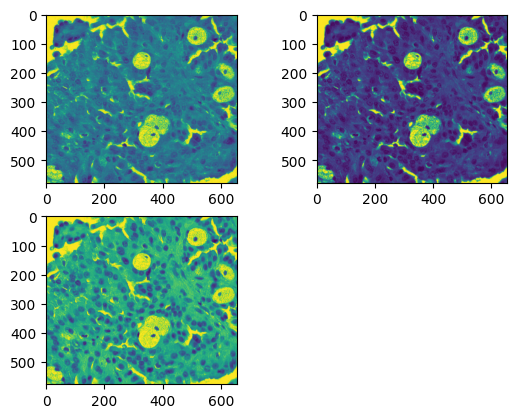

In [130]:
import numpy as np
import matplotlib.pyplot as plt
import torch

img = plt.imread("zellen.tif")[::2,::2,:3]/255 # Jedes zweite Pixel, nur RGB, ohne Alpha-Kanal

plt.figure()
plt.subplot(2,2,1)
plt.imshow(img[:,:,0])
plt.subplot(2,2,2)
plt.imshow(img[:,:,1])
plt.subplot(2,2,3)
plt.imshow(img[:,:,2])
plt.show()

[0.36787944 0.52729242 0.69767633 0.85214379 0.96078944 1.
 0.96078944 0.85214379 0.69767633 0.52729242 0.36787944]
(577, 654, 3)


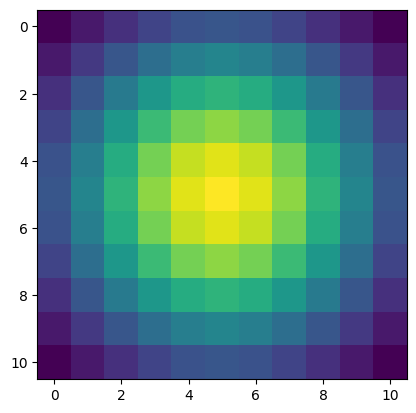

In [122]:
def pad_dat_boi(img, n=10):
    # Zero-Padding
    h, w, c = img.shape
    padded = np.zeros((h+2*n,w+2*n, c))
    padded[n:h+n, n:w+n] = img
    padded[:n,n:w+n] = img[:n][::-1]
    padded[h+n:,n:w+n] = img[h-n:][::-1]
    padded[:,:n] = padded[:,2*n:n:-1]
    padded[:,n+w-1:] = padded[:,n+w-1:w-2:-1]
    return padded

def conv(img, kernel):
    # 2D-Faltung (parallelisiert)
    h, w, c = img.shape
    k = kernel.shape[0]
    img_padded = pad_dat_boi(img, n=int(k/2))
    out = np.zeros((h, w, c))

    for xx in range(k):
        for yy in range(k):
            out += kernel[xx,yy]*img_padded[xx:h+xx, yy:w+yy]
    return out

# Definiere Kernel
k = 11 # Kernelgröße
sigma = 1 # Sigma
base = np.exp(-(np.linspace(-sigma, sigma, num=k))**2)
print(base)
kernel = base[:,None]*base[None]
kernel /= np.sum(kernel)
plt.figure()
plt.imshow(kernel)
plt.show()

# Falte Bild (Glättung)
glatt = conv(img, kernel)

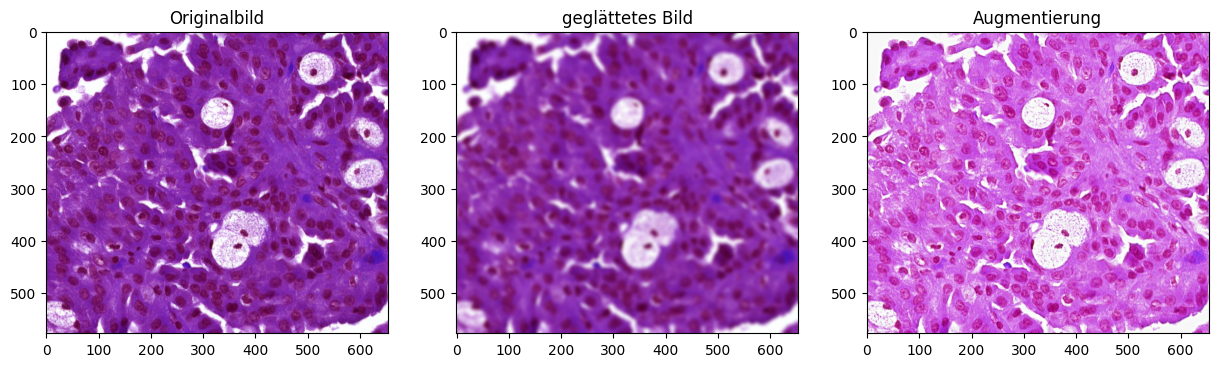

In [133]:
# Normalisierung glatt
glatt -= np.min(glatt)
glatt /= np.max(glatt)

# no_glatt: Ziehe niedrige Frequenzen ab (und normiere auf [0,1])
no_glatt = img-glatt
no_glatt -= np.min(no_glatt)
no_glatt /= np.max(no_glatt)

# Ausgabe ist strukturelle Umskalierung des Eingabebildes
out = img*no_glatt
out /= np.max(out)

# Polynom fürs Aufhellen
f = lambda x: 0.5*x**3-2*x**2+2.5*x # Polynom 3. Grades mit f(0)=0, f(1)=1, und Sattelpunkt bei (1,1)
for _ in range(2): # Führe Polynom zwei mal hintereinander aus (wird dann zu Polynom 6. Grades)
    out = f(out)

plt.figure(figsize=[15,30])
plt.subplot(1,3,1)
plt.imshow(img)
plt.title("Originalbild")
plt.subplot(1,3,2)
plt.imshow(glatt)
plt.title("geglättetes Bild")
plt.subplot(1,3,3)
plt.imshow(out)
plt.title("Augmentierung")
plt.show()


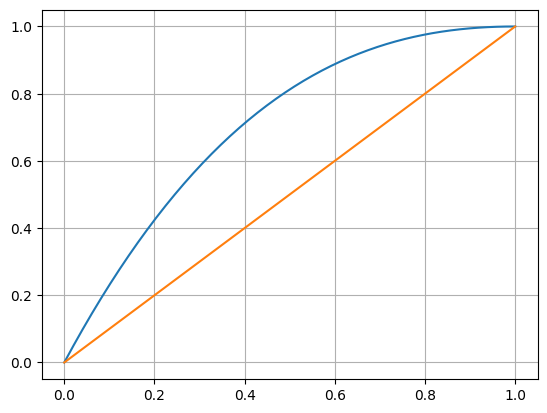

In [136]:
f = lambda x: 0.5*x**3-2*x**2+2.5*x
base = np.linspace(0,1)
y = base
for _ in range(1):
    y = f(y)
plt.figure()
plt.plot(base, y)
plt.plot(base, base)
plt.grid()
plt.show()